In [26]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import tempfile
import gzip
import pylhe
import math
from auxPlots import selectColor, xSecTest
from aux import getLHEevents, getDistributions, getInfo, getInfoSummary

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams['figure.max_open_warning'] = 50
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [27]:
def AddInfoToDistributions(distributions, model, process, mPsiT, mSDM, info, nlo = False):
    """Adds the model name, process and mass parameters to the final dictionary"""
    converter_dict = {'TopEFT': 'EFT', 'UV_BSM': '1-loop UV', 'sm':'SM',
                      'qq2ttbar_gs4_ydm2': r'$q q \to t \bar{t}$', 'gg2ttbar_gs4_ydm2': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs4_ydm2': r'$p p \to t \bar{t}$ ', 'qq2ttbar_gs6': r'$q q \to t \bar{t}$', 'gg2ttbar_gs6': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs6': r'$p p \to t \bar{t}$', 'qq2ttbar_gs4': r'$q q \to t \bar{t}$', 'gg2ttbar_gs4': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs4': r'$p p \to t \bar{t}$', 'gs4': r'$g_s^4$', 'gs6': r'$g_s^6$', 'ydm2': r'$y_{DM}^2$'}
    
    #Add new keys with the new information
    distributions['model'] = converter_dict[model]
    distributions['process'] = converter_dict[process]
    distributions['mass_params'] = (mPsiT,mSDM)
    distributions['ydm'] = info['(mSDM,mPsiT,mT,yDM)'][-1]

    if nlo == True:
        distributions['weights'] = distributions['nevents']*distributions['weights']

    
    #Correcting the weights when doing bias generation
    if abs((distributions['xsec (pb)']-info['xsec (pb)'])/info['xsec (pb)']) > 0.01 and nlo == True:
        distributions['weights'] = (info['xsec (pb)']/distributions['xsec (pb)']) * distributions['weights']
        distributions['xsec (pb)'] = info['xsec (pb)']
    

    #Extract the coupling order
    parts = process.split('_')
    parts = parts[1:]
    for i,p in enumerate(parts):
        parts[i] = converter_dict[p]

    distributions['cp_order'] = parts[1:]
    
    return distributions

In [28]:
#Reading files
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/Distributions/*/*/*.npz'))
data = []
data_sm = []
#Loading the distributions
for f in files:
    aux = np.load(f, allow_pickle = True)
    if aux['model'] == 'SM':
        data_sm.append(aux)
    else:
        data.append(aux)

data = sorted(data, key=lambda d: d['mass_params'][0])
print(data_sm[2]['process'])
print(data[4]['deltaPhi'], data[5]['model'])

$p p \to t \bar{t}$
[3.14159265 3.14159265 3.14159265 ... 3.14159265 3.14159265 3.14159265] EFT


In [29]:
#Reading files
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/*/*/*.npz'))
data_b = []
#Loading the distributions
for f in files:
    aux = np.load(f, allow_pickle = True)
    data_b.append(aux)

data_b = sorted(data_b, key=lambda d: d['mass_params'][0])

In [30]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/qq2ttbar_gs4_ydm2/Events/biasTest/*events.lhe.gz'))
data_s = []
info = []
for i,f in enumerate(files):
    d = getDistributions(f)
    if i == 0:
        info.append(getInfo(f, nlo = False))
        d = AddInfoToDistributions(d,'TopEFT','qq2ttbar_gs4_ydm2', 5000., 4750., info[0])
    else:
        info.append(getInfo(f, nlo = True))
        d = AddInfoToDistributions(d,'UV_BSM','qq2ttbar_gs4_ydm2', 5000., 4750., info[1], nlo= True)

    data_s.append(d)



In [31]:
print(files)

['/home/vinicius/EFT_ToyModel/processFolders/TopEFT/qq2ttbar_gs4_ydm2/Events/biasTest/unweighted_events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/UV_BSM/qq2ttbar_gs4_ydm2/Events/biasTest/events.lhe.gz']


In [32]:
print((8.5029e-05/6.5920865e-04)**(-1) )

7.752750826188711


In [33]:
xSecTest(data_s)

EFT $q q \to t \bar{t}$  mPsiT: 5000.0, mSDM: 4750.0 Result: Passed
1-loop UV $q q \to t \bar{t}$  mPsiT: 5000.0, mSDM: 4750.0 Result: Passed


In [34]:
 for d in data_s:
    print(d['mass_params'][0], d['model'], d['nevents'])

5000.0 EFT 50000
5000.0 1-loop UV 103483


In [35]:
print(data_s[0]['y_t'])

[-0.94293241  2.1593101  -1.55135495 ... -3.08918778 -0.4227721
 -1.34142864]


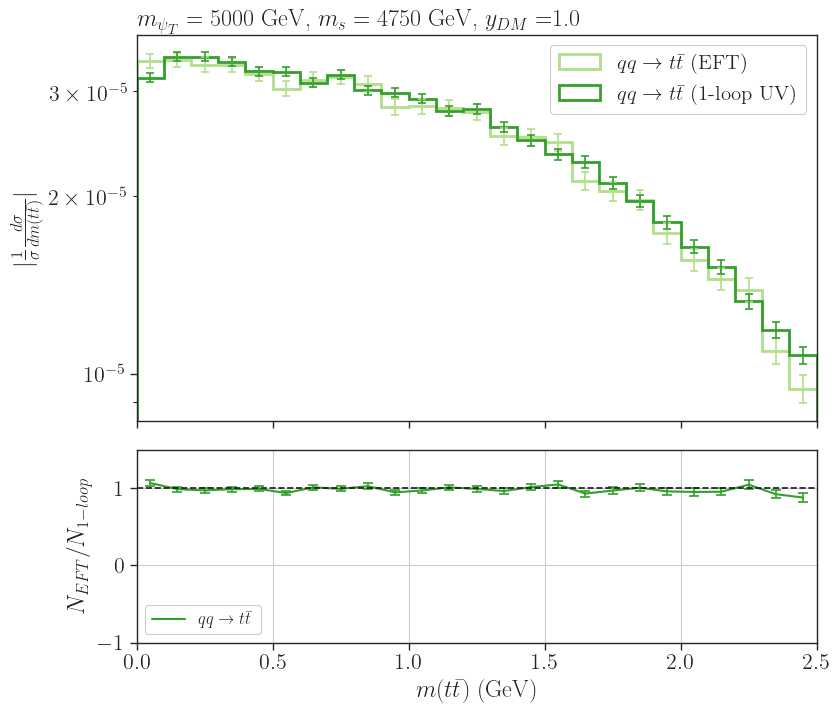

In [38]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
hists_norm = []
hErr_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(0,2.6,0.1)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#   label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                         # color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         #linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        #Cs and weights test
        #if model == '1-loop UV':
        #   print('UV:', d['nevents']*sum(d['weights']), d['xsec (pb)'])
        #else:
        #   print('EFT:', sum(d['weights']), d['xsec (pb)'])
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(abs(d['y_t']),bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(abs(d['y_t']),bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hLoop_Err = histsErr[1]
hEFT = hists[0]
hEFT_Err = histsErr[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

# Invariant mass $qq\to t\bar{t}$

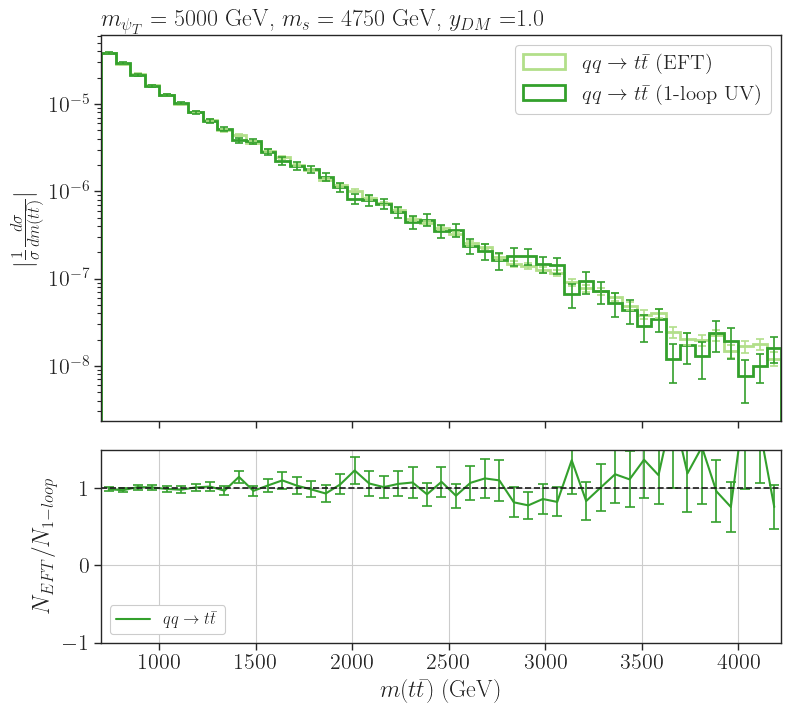

In [12]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
hists_norm = []
hErr_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(700.,4300.,75.)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#   label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                         # color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         #linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        #Cs and weights test
        #if model == '1-loop UV':
        #   print('UV:', d['nevents']*sum(d['weights']), d['xsec (pb)'])
        #else:
        #   print('EFT:', sum(d['weights']), d['xsec (pb)'])
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists_norm[1]
hLoop_Err = hErr_norm[1]
hEFT = hists_norm[0]
hEFT_Err = hErr_norm[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

# Without bias 
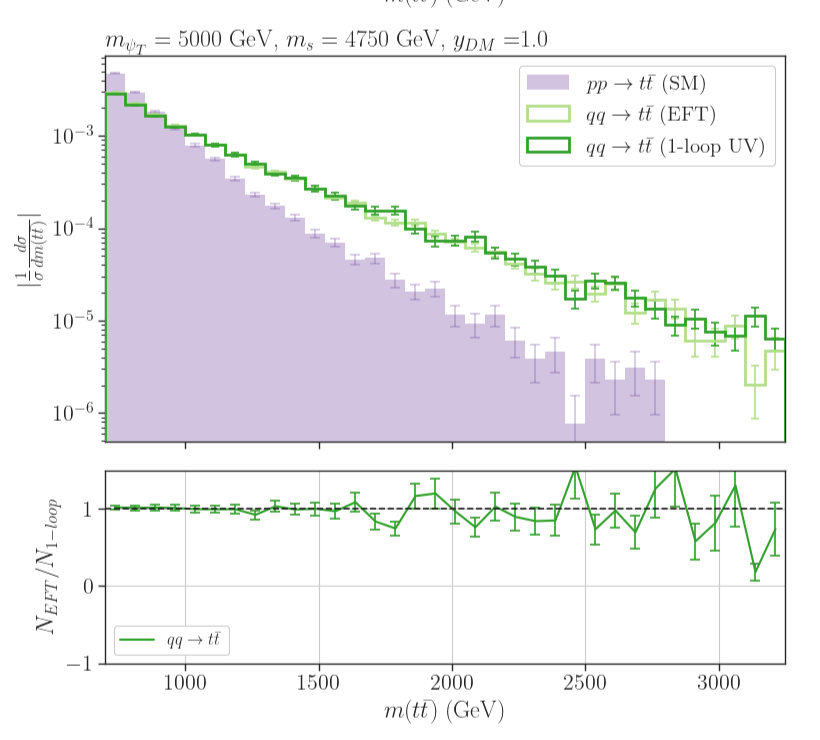

In [13]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/qq2ttbar_gs4_ydm2/Events/biasTest1/*events.lhe.gz'))
data_s1 = []
info = []
for i,f in enumerate(files):
    d = getDistributions(f)
    if i == 0:
        info.append(getInfo(f, nlo = False))
        d = AddInfoToDistributions(d,'TopEFT','qq2ttbar_gs4_ydm2', 5000., 4750., info[0])
    else:
        info.append(getInfo(f, nlo = True))
        d = AddInfoToDistributions(d,'UV_BSM','qq2ttbar_gs4_ydm2', 5000., 4750., info[1], nlo= True)

    data_s1.append(d)



In [14]:
xSecTest(data_s1)

EFT $q q \to t \bar{t}$  mPsiT: 5000.0, mSDM: 4750.0 Result: Passed
1-loop UV $q q \to t \bar{t}$  mPsiT: 5000.0, mSDM: 4750.0 Result: Passed


In [15]:
for d in data_s1:
    print(d['mass_params'][0], d['model'], d['nevents'])
print(75000/103464)

5000.0 EFT 75000
5000.0 1-loop UV 103464
0.7248898167478544


In [16]:
#selecting the events without bias with mass 5000 and 4750
select_b = []
select = []
for d in data_b:
    if d['mass_params'][0] == 5000.0:
        select_b.append(d)
for d in data:
    if d['mass_params'][0] == 5000.0:
        select.append(d)

1-loop UV [4.3704436e-09 8.0163381e-09 6.7028206e-09 ... 9.0324894e-09 2.6286368e-10
 2.4634196e-09]
['0', '0', '0', 'No bias (1-loop UV)']
1-loop UV [2.70613255e-09 3.26600388e-08 3.45881057e-08 ... 1.68098201e-10
 1.22026070e-07 2.38181507e-08]
['0', '0', '0', 'No bias (1-loop UV)', '0', '0', '0', 'Bias (1-loop UV)']
0.9981878115366909


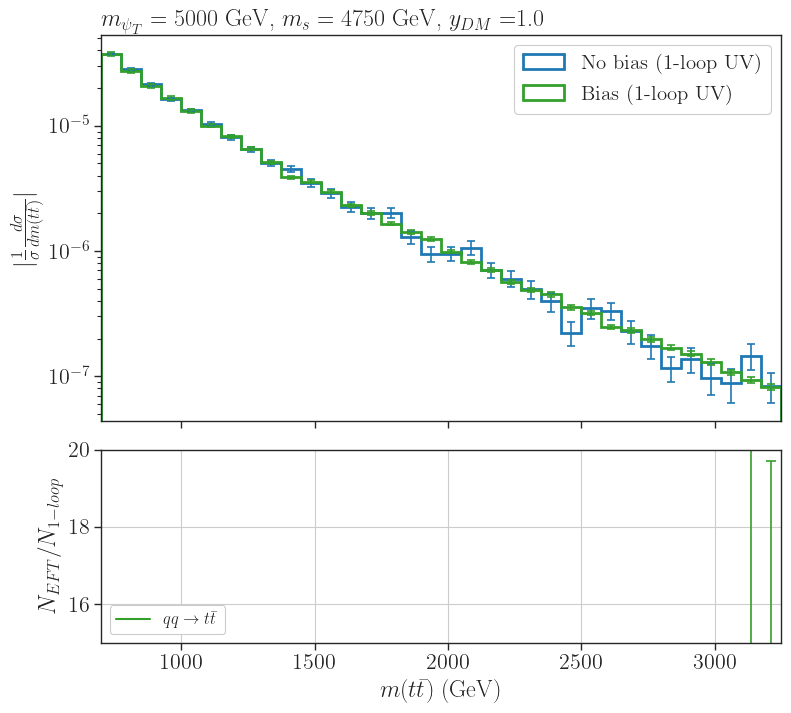

In [17]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected =  select + select_b

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = ['0', sns.color_palette('Paired')[0], '0', sns.color_palette('Paired')[1], '0',
     sns.color_palette('Paired')[2], '0', sns.color_palette('Paired')[3]]
hists_norm = []
hErr_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(700.,3300.,75.)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#   label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                         # color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         #linewidth=0,fill=True,stacked=True,linestyle='solid')  



for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        continue
    elif d['model'] == 'EFT':
        labels.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        print(model, weights)
        if j < 4:
            pmodels.append(r'%s (%s)' %('No bias',model))
        else:
            pmodels.append(r'%s (%s)' %('Bias',model))
        #Cs and weights test
        #if model == '1-loop UV':
        #   print('UV:', d['nevents']*sum(d['weights']), d['xsec (pb)'])
        #else:
        #   print('EFT:', sum(d['weights']), d['xsec (pb)'])
        label = pmodels[-1]
        labels.append(label)
        print(labels)
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step', 
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hLoop_Err = hErr[1]
hEFT = hists[0]
hEFT_Err = hErr[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
print(np.mean(ratio))
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(15,20)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

['0', 'No bias (EFT)']
['0', 'No bias (EFT)', '0', '0', '0', 'Bias (EFT)']


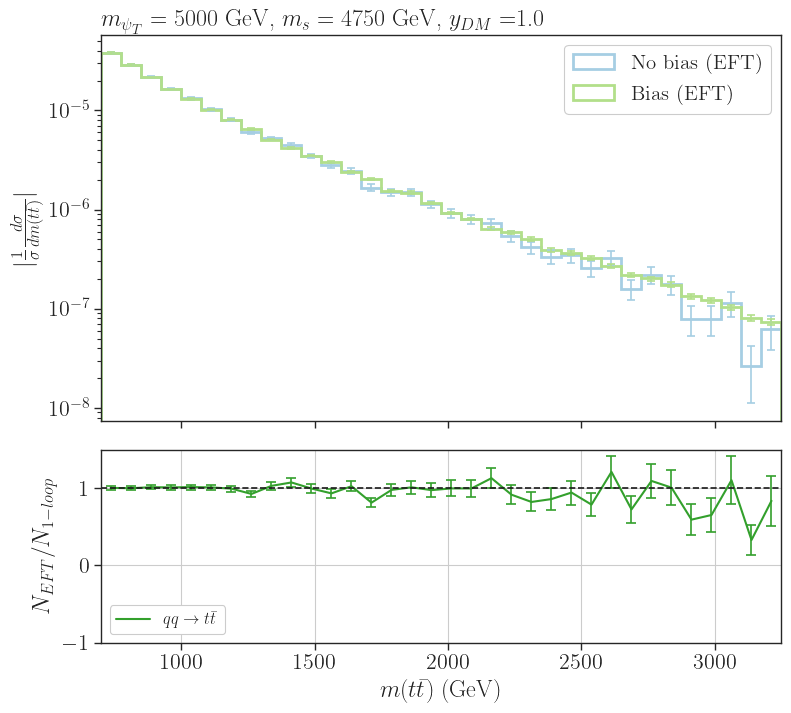

In [18]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected =  select + select_b

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = ['0', sns.color_palette('Paired')[0], '0', sns.color_palette('Paired')[1], '0',
     sns.color_palette('Paired')[2], '0', sns.color_palette('Paired')[3]]
hists_norm = []
hErr_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(700.,3300.,75.)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#   label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                         # color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         #linewidth=0,fill=True,stacked=True,linestyle='solid')  



for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        continue
    elif d['model'] == '1-loop UV':
        labels.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        if j < 4:
            pmodels.append(r'%s (%s)' %('No bias',model))
        else:
            pmodels.append(r'%s (%s)' %('Bias',model))
        #Cs and weights test
        #if model == '1-loop UV':
        #   print('UV:', d['nevents']*sum(d['weights']), d['xsec (pb)'])
        #else:
        #   print('EFT:', sum(d['weights']), d['xsec (pb)'])
        label = pmodels[-1]
        labels.append(label)
        print(labels)
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists_norm[1]
hLoop_Err = hErr_norm[1]
hEFT = hists_norm[0]
hEFT_Err = hErr_norm[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()


# $p_T$ $qq\to t\bar{t}$

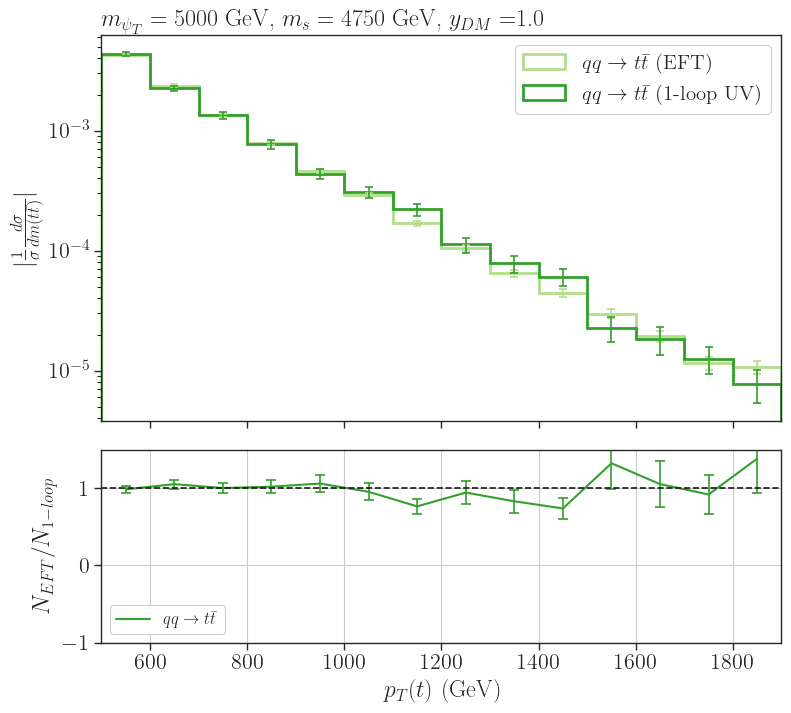

In [19]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
hErr_norm = []
hists_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(500.,2000.,100.)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#    label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                       #   color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                        # linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists_norm[1]
hLoop_Err = hErr_norm[1]
hEFT = hists_norm[0]
hEFT_Err = hErr_norm[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
    #Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
    
plt.show()

# Without bias
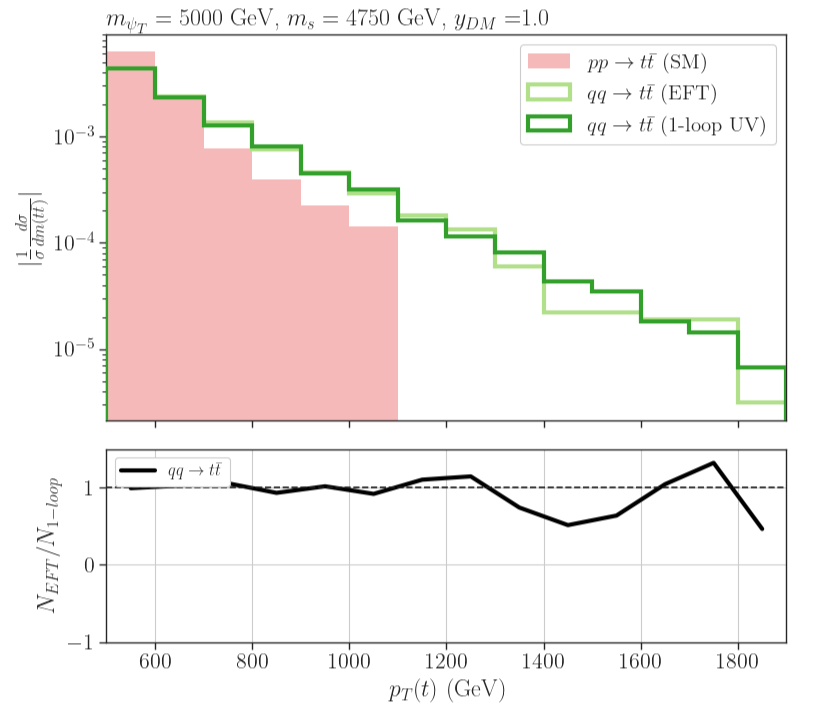


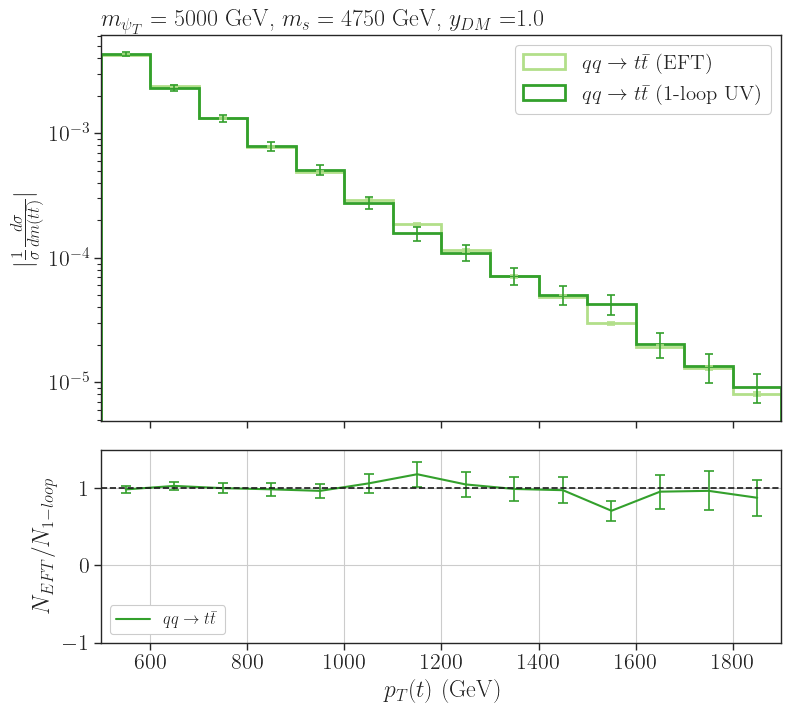

In [20]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s1

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
hErr_norm = []
hists_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(500.,2000.,100.)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#    label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                       #   color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                        # linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists_norm[1]
hLoop_Err = hErr_norm[1]
hEFT = hists_norm[0]
hEFT_Err = hErr_norm[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
        #Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
    
plt.show()

# $qq\to t\bar{t}$

In [21]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/gg2ttbar_gs4_ydm2/Events/run_Stest/*events.lhe.gz'))
data_s = []
for i,f in enumerate(files):
    d = getDistributions(f)
    if i == 0:
        d = AddInfoToDistributions(d,'TopEFT','gg2ttbar_gs4_ydm2', 2000., 1900.)
    else:
        d = AddInfoToDistributions(d,'UV_BSM','gg2ttbar_gs4_ydm2', 2000., 1900.)
    data_s.append(d)


In [22]:
print(files)

[]


IndexError: list index out of range

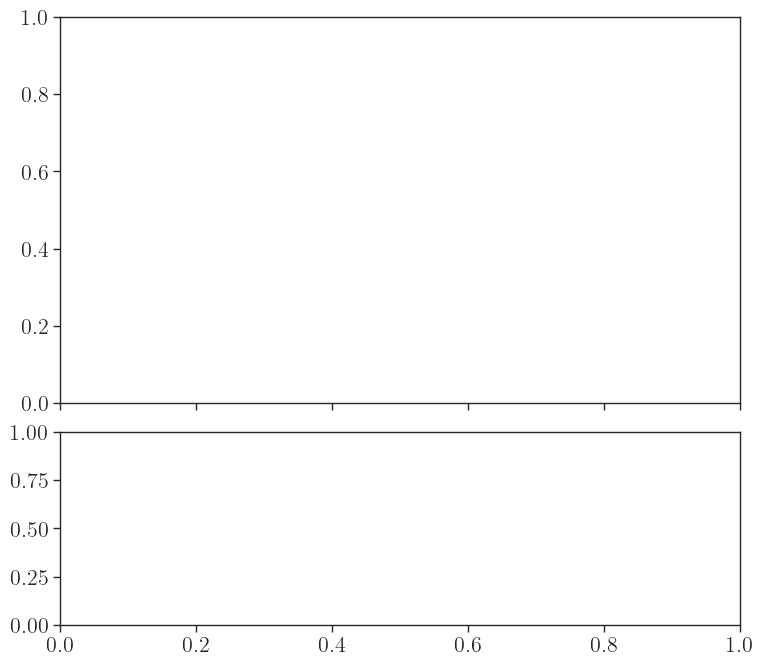

In [23]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(400.,2000.,75.)

#Loop over the processes and models

#SM plot
labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
#Plotting the SM hist
axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$q q \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=3,fill=False,zorder=i,linestyle='solid')
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hEFT = hists[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$g g \to t \bar{t}$']
    
ratio = np.divide(hEFT/sum(hEFT) , hLoop/sum(hLoop), out=np.zeros_like(hLoop),where=hLoop != 0)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[0])
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(0,1.2)
axarr[1].set_yticks(np.arange(0,1.2,0.1))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

In [ ]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(500.,2000.,100.)

#Loop over the processes and models

#SM plot
labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
#Plotting the SM hist
axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$q q \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=3,fill=False,zorder=i,linestyle='solid')
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hEFT = hists[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$g g \to t \bar{t}$']
    
ratio = np.divide(hEFT/sum(hEFT) , hLoop/sum(hLoop), out=np.zeros_like(hLoop),where=hLoop != 0)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[0])
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$pT(t)$ (GeV)')
    
plt.show()

In [ ]:
x = 0.001001570/0.081606587 * 228892
y = 0.001171937/0.054321553 * 160749
z = 0.001193567/0.038704574 * 101359
print(x, y, z)